# Fake News Detection
The dataset is fully prepped for model use and has complete labels. The True articles are sourced from The New York Times website, while the fabricated (Fake) articles are retrieved from the AFP Fact Check website.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore') 

## Loading the dataset

In [2]:
data = pd.read_csv(r'Data\News.csv')
data.head()

,text,label
0,sing praise mahinda lose voice sri lanka disro...,1
1,kojc rally first time davao city appoint son god,1
2,bill gate people resist mrna tsunami exclude s...,1
3,cure covid19 forward budesonide asthma drug pl...,1
4,president trump form patriot party 81 day elec...,1


In [3]:
print(f"This data has {data.shape[0]} articles")

This data has 12520 articles


# Check Missing Values:

In [4]:
data.isna().sum()

text     0
label    0
dtype: int64

## Check the bias in the data:

In [5]:
class_counts = data['label'].value_counts()
print(class_counts)

label
1    6996
0    5524
Name: count, dtype: int64


In [6]:
print(f'The bias ratio in the data is {5524/6996:.2f}')

The bias ratio in the data is 0.79


In [7]:
# Calculate percentage distribution
class_percentage = data['label'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
print(class_percentage)


Percentage Distribution:
label
1    55.878594
0    44.121406
Name: proportion, dtype: float64


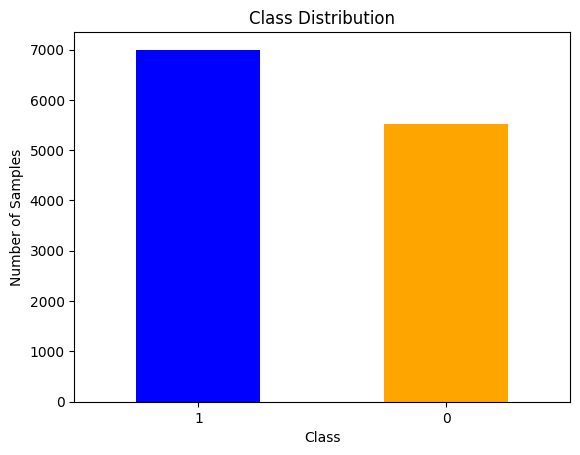

In [8]:
# Plot class distribution
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

## Handel the bias in the data:

In [9]:
# Split the dataset by label
df_minority = data[data['label'] == 0]  # Minority class (label=0)
df_majority = data[data['label'] == 1]  # Majority class (label=1)

# Perform undersampling (reduce majority class to the size of minority class)
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine the undersampled majority class with the minority class
df_balanced = pd.concat([df_minority, df_majority_undersampled])

# Shuffle the dataset (optional, but recommended for randomization)
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

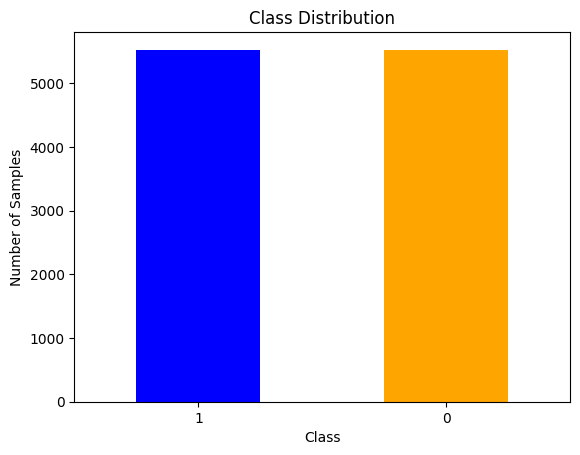

In [10]:
class_counts = df['label'].value_counts()
# Plot class distribution
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

# Check Empty text in the data:

In [11]:
blanks = []

for index, text in df['text'].items():  
    if isinstance(text, str) and text.isspace():  
        blanks.append(index)

print(f"There {'is' if len(blanks) == 1 else 'are'} {len(blanks)} empty text(s) in the data")


There are 0 empty text(s) in the data


## Apply Lemmatization :

In [15]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [16]:
# Apply lemmatization to the 'text' column
df['cleaned_text'] = df['text'].apply(lemmatize_text)

## preparing X and y

In [17]:
X = df[['cleaned_text']]
X.head()

,cleaned_text
0,atms close sic day probably ransomeware sic cy...
1,humble tribute hero salman shah look internati...
2,translate english post title read gasoline tru...
3,sikh community initiative ukraine guru ka langar
4,world business briefingafrica south africa ang...


In [18]:
y = df[['label']]
y.head()

,label
0,1
1,1
2,1
3,1
4,0


## Data Preprocessing:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Output the shapes of the training and test sets
print(f'Train: {y_train.shape}, Test: {y_test.shape}')

Train: (8838, 1), Test: (2210, 1)


In [21]:
X_train = X_train['cleaned_text'].tolist()
X_test = X_test['cleaned_text'].tolist()

In [22]:
# Convert the text to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)



# Fit-transform the training data
X_trainV = vectorizer.fit_transform(X_train).toarray()

# Transform the test data (no need to reshape)
X_testV = vectorizer.transform(X_test).toarray()

# Check the shapes
print(X_trainV.shape)
print(X_testV.shape)


(8838, 5000)
(2210, 5000)


# Model Training:

In [23]:
def evaluate_model(true, predicted):
    # Accuracy
    accuracy = accuracy_score(true, predicted)
    
    # Precision (micro, macro, weighted average for multi-class)
    precision = precision_score(true, predicted, average='weighted')
    
    # Recall (micro, macro, weighted average for multi-class)
    recall = recall_score(true, predicted, average='weighted')
    
    # F1-Score (micro, macro, weighted average for multi-class)
    f1 = f1_score(true, predicted, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(true, predicted)
    
    return accuracy, precision, recall, f1, cm

In [24]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42),
    "Random Forest" : RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting':  GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=42)
}

In [25]:
model_list = []
Acc_list =[]
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_trainV, y_train) # Train model

    # Make predictions
    ytrain_pred = model.predict(X_trainV)
    ytest_pred = model.predict(X_testV)
    
    # Evaluate Train and Test dataset
    train_acc, train_pre, train_rec, train_f1, train_cm = evaluate_model(y_train, ytrain_pred)

    test_acc, test_pre, test_rec, test_f1, test_cm = evaluate_model(y_test, ytest_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(train_acc))
    print("- precision: {:.4f}".format(train_pre))
    print("- recall: {:.4f}".format(train_rec))
    print("- F1-Score: {:.4f}".format(train_f1))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(test_acc))
    print("- precision: {:.4f}".format(test_pre))
    print("- recall: {:.4f}".format(test_rec))
    print("- F1-Score: {:.4f}".format(test_f1))
    Acc_list.append(test_acc)
    
    print('='*35)
    print('\n')

  File "c:\Users\pc lenovo\OneDrive\Documents\GitHub\Fake-News-detection\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KNN
Model performance for Training set
- Accuracy: 0.9167
- precision: 0.9178
- recall: 0.9167
- F1-Score: 0.9167
----------------------------------
Model performance for Test set
- Accuracy: 0.8276
- precision: 0.8292
- recall: 0.8276
- F1-Score: 0.8274


Naive Bayes
Model performance for Training set
- Accuracy: 0.8958
- precision: 0.9119
- recall: 0.8958
- F1-Score: 0.8947
----------------------------------
Model performance for Test set
- Accuracy: 0.7828
- precision: 0.7953
- recall: 0.7828
- F1-Score: 0.7806


Decision Tree
Model performance for Training set
- Accuracy: 0.6013
- precision: 0.7463
- recall: 0.6013
- F1-Score: 0.5321
----------------------------------
Model performance for Test set
- Accuracy: 0.5991
- precision: 0.7373
- recall: 0.5991
- F1-Score: 0.5321


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- precision: 1.0000
- recall: 1.0000
- F1-Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8991
- 

In [26]:
pd.DataFrame(list(zip(model_list, Acc_list)), columns=['Model', 'Accuracy']).sort_values(by=["Accuracy"],ascending=False)

,Model,Accuracy
3,Random Forest,0.899095
0,KNN,0.827602
1,Naive Bayes,0.782805
4,Gradient Boosting,0.741629
2,Decision Tree,0.599095


## Evaluate the Random Forest model:

In [27]:
model = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True)

model.fit(X_trainV, y_train)

y_pred = model.predict(X_testV)

acc, pre, rec, f1, cm = evaluate_model(y_test, y_pred)
print(f'Accuracy: {acc:2f}, Precision: {pre:2f}, Recall: {rec:2f}, F1 score: {f1:2f}')


Accuracy: 0.899095, Precision: 0.899322, Recall: 0.899095, F1 score: 0.899074


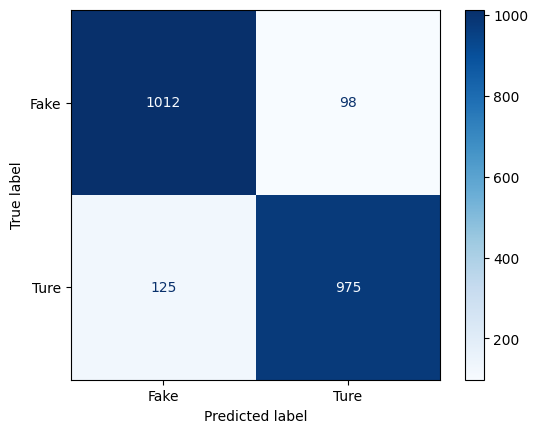

In [28]:
# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Ture'])  # adjust labels based on your classes

# Plot the confusion matrix
disp.plot(cmap='Blues')  # You can change the color map if needed
plt.show()

## LSTM Model: